In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt


In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_data = 1000
seed=1
n_clusters = 4

# Generate random Gaussian blobs and run k-means
blobs, blob_labels = make_blobs(n_samples=n_data, n_features=2, centers=n_clusters, random_state=seed)
clusters_blob = KMeans(n_clusters=n_clusters, random_state=seed).fit_predict(blobs)

# Generate data uniformly at random and run k-means
uniform = np.random.rand(n_data, 2)
clusters_uniform = KMeans(n_clusters=n_clusters, random_state=seed).fit_predict(uniform)


/Users/maruanottoni/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/maruanottoni/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(-0.048010108904901164,
 1.0495656858449405,
 -0.047543480487357986,
 1.0496620815151285)

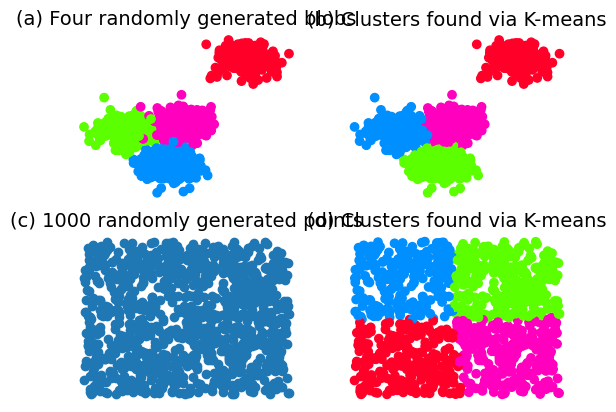

In [10]:
# Matplotlib incantations for visualizing results
figure = plt.figure()
plt.subplot(221)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap='gist_rainbow')
plt.title("(a) Four randomly generated blobs", fontsize=14)
plt.axis('off')
plt.subplot(222)
plt.scatter(blobs[:, 0], blobs[:, 1], c=clusters_blob, cmap='gist_rainbow')
plt.title("(b) Clusters found via K-means", fontsize=14)
plt.axis('off')
plt.subplot(223)
plt.scatter(uniform[:, 0], uniform[:, 1])
plt.title("(c) 1000 randomly generated points", fontsize=14)
plt.axis('off')
plt.subplot(224)
plt.scatter(uniform[:, 0], uniform[:, 1], c=clusters_uniform, cmap='gist_rainbow')
plt.title("(d) Clusters found via K-means", fontsize=14)
plt.axis('off')

/Users/maruanottoni/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


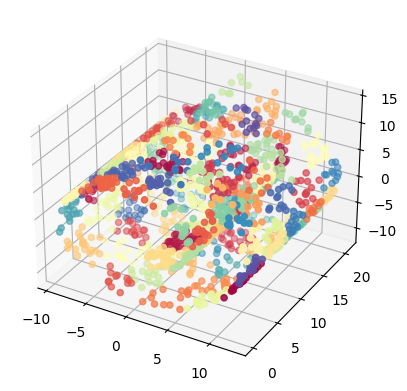

In [13]:
from sklearn.cluster import KMeans
from sklearn import manifold, datasets
import matplotlib.pyplot as plt

# Generate a noisy Swiss roll dataset
X, color = datasets.make_swiss_roll(n_samples=1500)

# Approximate the data with 100 k-means clusters
clusters_swiss_roll = KMeans(n_clusters=100, random_state=1).fit_predict(X)

# Plot the dataset with k-means cluster IDs as the color
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral')

* If the data is distributed uniformly throughout the space, then picking the right k boils down to a sphere-packing problem. In d dimensions, one could fit roughly 1/rd spheres of radius r. Each k-means cluster is a sphere, and the radius is the maximum error of representing points in that sphere with the centroid. So, if we are willing to tolerate a maximum approximation error of r per data point, then the number of clusters is O(1/rd), where d is the dimension of the original feature space of the data.

In [16]:
import numpy as np
from sklearn.cluster import KMeans

class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships. ...
    This transformer runs k-means on the input data and converts each data point
    into the ID of the closest cluster. If a target variable is present, it is
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together. ... """
    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state

    def fit(self, X, y=None):
        """Runs k-means on the input data and finds centroids."""
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self
        else:
            # There is target information. Apply appropriate scaling and include
            # it in the input data to k-means.
            data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))
            
            # Build a pre-training k-means model on data and target
            km_model_pretrain = KMeans(n_clusters=self.k, n_init=20, random_state=self.random_state)
            km_model_pretrain.fit(data_with_target)
            
            # Run k-means a second time to get the clusters in the original space
            # without target info. Initialize using centroids found in pre-training.
            # Go through a single iteration of cluster assignment and centroid recomputation.
            km_model = KMeans(n_clusters=self.k, init=km_model_pretrain.cluster_centers_[:,:2], n_init=1, max_iter=1)
            km_model.fit(X)
            self.km_model = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

    def transform(self, X, y=None):
        """Outputs the closest cluster ID for each input data point."""
        clusters = self.km_model.predict(X)
        return clusters[:,np.newaxis]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)


In [20]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons
training_data, training_labels = make_moons(n_samples=2000, noise=0.2)
kmf_hint = KMeansFeaturizer(k=100, target_scale=10).fit(training_data, training_labels)
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0).fit(training_data, training_labels)
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the k-means clusters overlaid with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

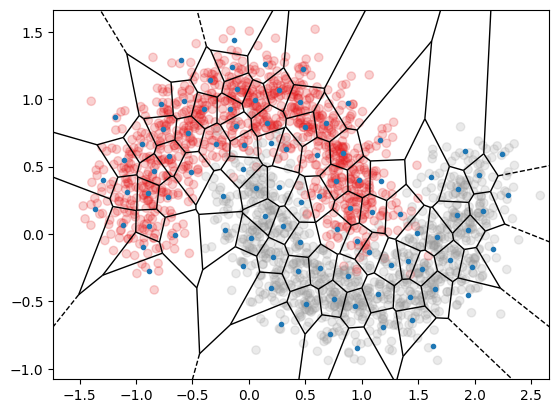

In [21]:
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, plt.gca())

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import scipy.sparse
import sklearn.metrics

### Generate some test data from the same distribution as training data
test_data, test_labels = make_moons(n_samples=2000, noise=0.3)
### Use the k-means featurizer to generate cluster features
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

### Form new input features with cluster features
training_with_cluster = scipy.sparse.hstack((training_data, training_cluster_features))
test_with_cluster = scipy.sparse.hstack((test_data, test_cluster_features))

### Build the classifiers
lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster, training_labels)
classifier_names = ['LR',
                    'kNN',
                    'RBF SVM',
                    'Random Forest',
                    'Boosted Trees']

classifiers = [LogisticRegression(random_state=seed),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               GradientBoostingClassifier(n_estimators=10, learning_rate=1.0)]

for model in classifiers:
    model.fit(training_data, training_labels)

### Helper function to evaluate classifier performance using ROC >>>
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)
    return fpr, tpr

### Plot results
import matplotlib.pyplot as plt
plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'r-', label='LR with k-means')
for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()


ValueError: could not broadcast input array from shape (2000,2) into shape (2000,)

* __The key intuition with stacking is to push the nonlinearities into the features and use a very simple, usually linear model as the last layer. The featurizer can be trained off‐ line, which means that one can use expensive models that require more computation power or memory but generate useful features. The simple model at the top level can be quickly adapted to the changing distributions of online data. This is a great trade- off between accuracy and speed, and this strategy is often used in applications like targeted advertising that require fast adaptation to changing data distributions.__


* This chapter illustrated the concept of model stacking using a somewhat unconven‐ tional approach: combining supervised k-means with a simple linear classifier. k- means is usually used as an unsupervised modeling method to find dense clusters of data points in feature space. Here, however, k-means is optionally given the class labels as input. This helps k-means to find clusters that better align with the bound‐ ary between classes.

* Deep learning, which we will discuss in the next chapter, takes model stacking to a whole new level by layering neural networks on top of one another. Two recent win‐ ners of the ImageNet Large Scale Visual Recognition Challenge involved 13 and 22 layers of neural networks. They take advantage of the availability of lots of unlabeled training images and look for combinations of pixels that yield good image fea‐ tures. The technique in this chapter separately trains the k-means featurizer from the linear classifier. But it’s possible to jointly optimize the featurizer and the classier. As we shall see, deep learning training takes the latter route.